In [28]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    log_loss,
    classification_report,
    confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import optuna
import mlflow
import mlflow.sklearn

import matplotlib.pyplot as plt
import seaborn as sns


In [29]:
df = pd.read_csv("processed_churn.csv")


In [30]:
df.head().T

,0,1,2,3,4
tenure,1.00,34.00,2.00,45.0,2.0
Contract_Two year,0.00,0.00,0.00,0.0,0.0
TenureServicesScore,1.00,102.00,6.00,135.0,2.0
InternetType,1.00,1.00,1.00,1.0,2.0
Fiber_Monthly,0.00,0.00,0.00,0.0,70.7
InternetService_Fiber optic,0.00,0.00,0.00,0.0,1.0
IsNewCustomer,1.00,0.00,1.00,0.0,1.0
IsLongCustomer,0.00,1.00,0.00,1.0,0.0
MonthlyCharges,29.85,56.95,53.85,42.3,70.7
PaymentMethod_Electronic check,1.00,0.00,0.00,0.0,1.0


In [31]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [33]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )
}

In [34]:
comparison = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [35]:

for name, model in models.items():
    
    pipeline = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("scaler", RobustScaler()),
        ("model", model)
    ])
    
    # 1) Train Metrics
    pipeline.fit(X_train, y_train)

    train_pred = pipeline.predict(X_train)
    train_proba = pipeline.predict_proba(X_train)[:, 1]

    train_acc = accuracy_score(y_train, train_pred)
    train_auc = roc_auc_score(y_train, train_proba)
    train_loss = log_loss(y_train, train_proba)

    # 2) Validation Metrics (Cross-Validation)
    val_acc = cross_val_score(
        pipeline, X_train, y_train,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1
    ).mean()

    val_auc = cross_val_score(
        pipeline, X_train, y_train,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1
    ).mean()

    val_loss = -cross_val_score(
        pipeline, X_train, y_train,
        scoring="neg_log_loss",
        cv=cv,
        n_jobs=-1
    ).mean()

    comparison.append([
        name, train_acc, val_acc, train_auc, val_auc, train_loss, val_loss
    ])

In [36]:
comparison_df = pd.DataFrame(
    comparison,
    columns=[
        "Model",
        "Train Accuracy", "Validation Accuracy",
        "Train AUC", "Validation AUC",
        "Train Loss", "Validation Loss"
    ]
)

print("\n=== Model Comparison Table ===\n")
display(comparison_df)


=== Model Comparison Table ===



,Model,Train Accuracy,Validation Accuracy,Train AUC,Validation AUC,Train Loss,Validation Loss
0,Logistic Regression,0.747604,0.749914,0.830756,0.827902,0.480565,0.484004
1,Random Forest,0.996095,0.774938,0.999706,0.811544,0.113091,0.624151
2,KNN,0.817536,0.731986,0.913119,0.771782,0.343198,2.670071
3,SVM,0.778843,0.760920,0.852245,0.812346,0.448629,0.498051
4,Decision Tree,0.996450,0.720094,0.999963,0.659720,0.005983,10.003211
5,Gradient Boosting,0.794995,0.781686,0.859638,0.838170,0.415584,0.441568
6,XGBoost,0.917465,0.771922,0.971640,0.813003,0.223880,0.499543


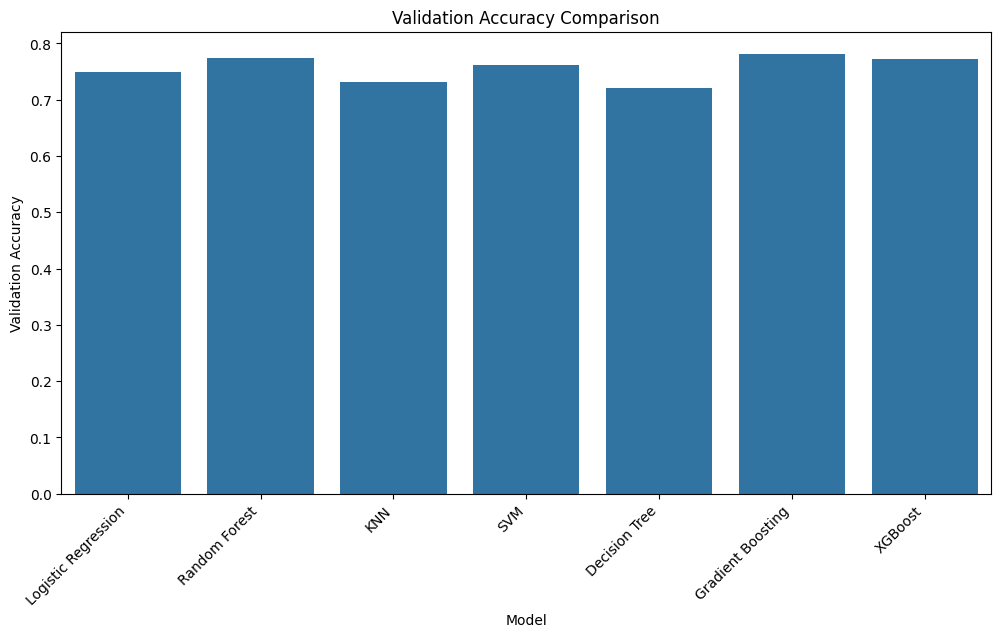

In [37]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=comparison_df,
    x="Model",
    y="Validation Accuracy"
)
plt.xticks(rotation=45, ha="right")
plt.title("Validation Accuracy Comparison")
plt.show()

In [ ]:

def objective(trial):

    model_name = trial.suggest_categorical(
        "model_name",
        ["logistic", "rf", "knn", "svm", "dt", "gb", "xgb"]
    )
    
    params = {}

    # -------------------------
    # Logistic Regression
    # -------------------------
    if model_name == "logistic":
        params["C"] = trial.suggest_float("C", 1e-3, 10.0, log=True)
        model = LogisticRegression(C=params["C"], max_iter=5000, n_jobs=-1)

    # -------------------------
    # Random Forest
    # -------------------------
    elif model_name == "rf":
        params["n_estimators"] = trial.suggest_int("n_estimators", 100, 400)
        params["max_depth"] = trial.suggest_int("max_depth", 3, 20)
        params["min_samples_split"] = trial.suggest_int("min_samples_split", 2, 10)
        params["min_samples_leaf"] = trial.suggest_int("min_samples_leaf", 1, 10)

        model = RandomForestClassifier(
            n_estimators=params["n_estimators"],
            max_depth=params["max_depth"],
            min_samples_split=params["min_samples_split"],
            min_samples_leaf=params["min_samples_leaf"],
            random_state=42,
            n_jobs=-1
        )

    # -------------------------
    # KNN
    # -------------------------
    elif model_name == "knn":
        params["n_neighbors"] = trial.suggest_int("n_neighbors", 3, 15)
        params["weights"] = trial.suggest_categorical("weights", ["uniform", "distance"])

        model = KNeighborsClassifier(
            n_neighbors=params["n_neighbors"],
            weights=params["weights"]
        )

    # -------------------------
    # SVM
    # -------------------------
    elif model_name == "svm":
        params["C"] = trial.suggest_float("C", 1e-3, 10.0, log=True)
        params["gamma"] = trial.suggest_float("gamma", 1e-4, 1.0, log=True)

        model = SVC(
            C=params["C"],
            gamma=params["gamma"],
            probability=True,
            random_state=42
        )

    # -------------------------
    # Decision Tree
    # -------------------------
    elif model_name == "dt":
        params["max_depth"] = trial.suggest_int("max_depth", 3, 20)
        params["criterion"] = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])

        model = DecisionTreeClassifier(
            max_depth=params["max_depth"],
            criterion=params["criterion"],
            random_state=42
        )

    # -------------------------
    # Gradient Boosting
    # -------------------------
    elif model_name == "gb":
        params["n_estimators"] = trial.suggest_int("n_estimators", 50, 400)
        params["learning_rate"] = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
        params["max_depth"] = trial.suggest_int("max_depth", 3, 10)

        model = GradientBoostingClassifier(
            n_estimators=params["n_estimators"],
            learning_rate=params["learning_rate"],
            max_depth=params["max_depth"],
            random_state=42
        )

    # -------------------------
    # XGBoost
    # -------------------------
    elif model_name == "xgb":
        params["n_estimators"] = trial.suggest_int("n_estimators", 100, 500)
        params["max_depth"] = trial.suggest_int("max_depth", 3, 10)
        params["learning_rate"] = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
        params["subsample"] = trial.suggest_float("subsample", 0.6, 1.0)
        params["colsample_bytree"] = trial.suggest_float("colsample_bytree", 0.6, 1.0)

        model = XGBClassifier(
            eval_metric="logloss",
            n_estimators=params["n_estimators"],
            max_depth=params["max_depth"],
            learning_rate=params["learning_rate"],
            subsample=params["subsample"],
            colsample_bytree=params["colsample_bytree"],
            random_state=42,
            n_jobs=-1,
            tree_method="hist"
        )

    # -------------------------
    # Pipeline
    # -------------------------
    pipeline = ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("scaler", RobustScaler()),
        ("model", model)
    ])

    # -------------------------
    # Cross Validation
    # -------------------------
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_acc_scores = cross_val_score(pipeline, X_train, y_train, scoring="accuracy", cv=cv, n_jobs=-1)
    val_auc_scores = cross_val_score(pipeline, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1)
    val_loss_scores = -cross_val_score(pipeline, X_train, y_train, scoring="neg_log_loss", cv=cv, n_jobs=-1)

    val_acc = val_acc_scores.mean()
    val_auc = val_auc_scores.mean()
    val_loss = val_loss_scores.mean()

    # -------------------------
    # Train Metrics (fit once)
    # -------------------------
    pipeline.fit(X_train, y_train)

    train_pred = pipeline.predict(X_train)
    train_proba = pipeline.predict_proba(X_train)[:, 1]

    train_acc = accuracy_score(y_train, train_pred)
    train_auc = roc_auc_score(y_train, train_proba)
    train_loss = log_loss(y_train, train_proba)

    # -------------------------
    # MLflow Logging
    # -------------------------
    with mlflow.start_run(nested=True):
        mlflow.log_param("model_name", model_name)
        mlflow.log_params(params)

        mlflow.log_metric("train_acc", train_acc)
        mlflow.log_metric("train_auc", train_auc)
        mlflow.log_metric("train_loss", train_loss)

        mlflow.log_metric("val_acc", val_acc)
        mlflow.log_metric("val_auc", val_auc)
        mlflow.log_metric("val_loss", val_loss)

    # Optuna uses only Validation AUC as optimization score
    return val_auc

In [47]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-12-06 20:18:45,440] A new study created in memory with name: no-name-1e993273-7829-438d-aed1-07329f462020
[I 2025-12-06 20:18:55,593] Trial 0 finished with value: 0.84059304057744 and parameters: {'model_name': 'rf', 'n_estimators': 121, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.84059304057744.
[I 2025-12-06 20:20:29,868] Trial 1 finished with value: 0.8252380898375714 and parameters: {'model_name': 'svm', 'C': 0.13606601558726236, 'gamma': 0.0004440276857608012}. Best is trial 0 with value: 0.84059304057744.
[I 2025-12-06 20:20:30,955] Trial 2 finished with value: 0.799697299104819 and parameters: {'model_name': 'knn', 'n_neighbors': 12, 'weights': 'uniform'}. Best is trial 0 with value: 0.84059304057744.
[I 2025-12-06 20:21:01,190] Trial 3 finished with value: 0.8271148851087957 and parameters: {'model_name': 'gb', 'n_estimators': 394, 'learning_rate': 0.10981335809666629, 'max_depth': 3}. Best is trial 0 with value: 0.840

In [48]:
experiment = mlflow.get_experiment_by_name("churn_optuna_models")
experiment_id = experiment.experiment_id

In [49]:
runs_df = mlflow.search_runs(experiment_ids=experiment_id)


In [50]:
results = runs_df[
    [
        "params.model_name",
        "metrics.train_acc", "metrics.train_auc", "metrics.train_loss",
        "metrics.val_acc",   "metrics.val_auc",   "metrics.val_loss"
    ]
].copy()

In [51]:
results.columns = [
    "model_name",
    "train_acc", "train_auc", "train_loss",
    "val_acc",   "val_auc",   "val_loss"
]

In [52]:
best_results = (
    results.sort_values("val_auc", ascending=False)
            .groupby("model_name")
            .first()
            .reset_index()
)

In [53]:
best_results = best_results.sort_values("val_auc", ascending=False)
display(best_results)


,model_name,train_acc,train_auc,train_loss,val_acc,val_auc,val_loss
4,rf,0.777778,0.859312,0.451920,0.769262,0.840795,0.469332
6,xgb,0.802094,0.870934,0.403070,0.782751,0.838359,0.442626
3,logistic,0.757011,0.836362,0.516060,0.757191,0.833585,0.518462
1,gb,0.833156,0.904889,0.357565,0.780443,0.832333,0.448305
5,svm,0.731097,0.835516,0.494254,0.704119,0.825238,0.492163
0,dt,0.778843,0.866291,0.419523,0.732519,0.803073,1.202472
2,knn,0.785055,0.877213,0.434385,0.739620,0.799697,1.222219


In [56]:
xgb_runs = runs_df[runs_df["params.model_name"] == "xgb"]
best_xgb_run = xgb_runs.sort_values("metrics.val_auc", ascending=False).iloc[0]


In [57]:
print("Best XGB Run ID:", best_xgb_run.run_id)
print("\nBest Hyperparameters:\n")
best_xgb_run[best_xgb_run.index.str.contains("params.")]


Best XGB Run ID: 2683203c0b834a7e82eb922a3470b3dd

Best Hyperparameters:



params.C                                    None
params.model_name                            xgb
params.gamma                                None
params.learning_rate        0.012440568527549468
params.n_estimators                          421
params.max_depth                               5
params.min_samples_leaf                     None
params.min_samples_split                    None
params.colsample_bytree       0.6508746318261747
params.subsample               0.626776544018273
params.weights                              None
params.n_neighbors                          None
params.criterion                            None
Name: 10, dtype: object

In [58]:
best_xgb_params = {
    "n_estimators": 421,
    "max_depth": 5,
    "learning_rate": 0.012440568527549468,
    "subsample": 0.626776544018273,
    "colsample_bytree": 0.6508746318261747,
    "eval_metric": "logloss",
    "random_state": 42,
    "n_jobs": -1,
    "tree_method": "hist"
}

In [59]:
final_xgb = XGBClassifier(**best_xgb_params)


In [60]:
final_pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", RobustScaler()),
    ("model", final_xgb)
])

In [61]:
final_pipeline.fit(X_train, y_train)


,steps,"[('smote', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"
,copy,True


In [62]:
test_proba = final_pipeline.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= 0.5).astype(int)

In [63]:
test_auc  = roc_auc_score(y_test, test_proba)
test_acc  = accuracy_score(y_test, test_pred)
test_loss = log_loss(y_test, test_proba)


In [64]:
print("Test Accuracy:", test_acc)
print("Test AUC:", test_auc)
print("Test Log Loss:", test_loss)

print("\nClassification Report:")
print(classification_report(y_test, test_pred))

Test Accuracy: 0.772888573456352
Test AUC: 0.8356687075357151
Test Log Loss: 0.4471327833313115

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1035
           1       0.56      0.67      0.61       374

    accuracy                           0.77      1409
   macro avg       0.72      0.74      0.72      1409
weighted avg       0.79      0.77      0.78      1409



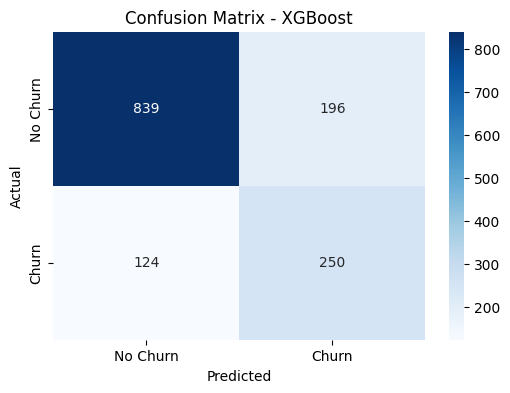

In [65]:
cm = confusion_matrix(y_test, test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

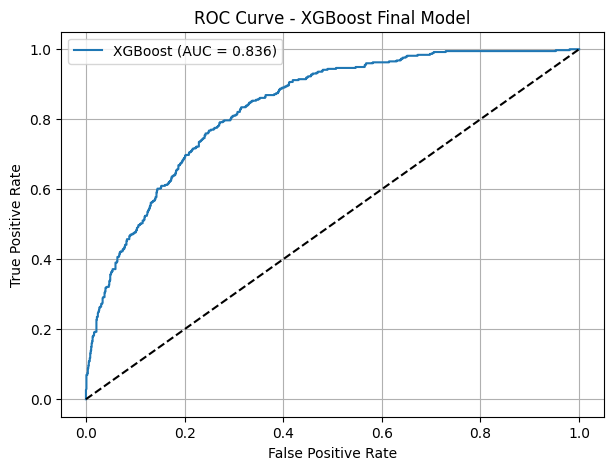

In [67]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost Final Model")
plt.legend()
plt.grid()
plt.show()

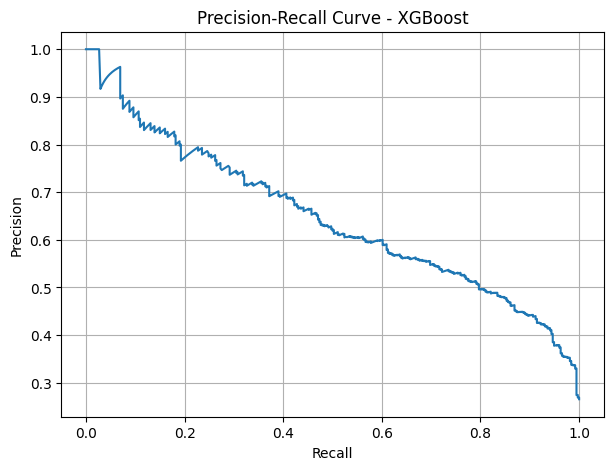

In [69]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, test_proba)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label="XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - XGBoost")
plt.grid()
plt.show()

In [70]:
import joblib

joblib.dump(final_pipeline, "final_xgb_pipeline.pkl")
print("Model saved as final_xgb_pipeline.pkl")

Model saved as final_xgb_pipeline.pkl


In [71]:
with mlflow.start_run(run_name="final_xgb_model"):
    mlflow.log_metric("test_acc", test_acc)
    mlflow.log_metric("test_auc", test_auc)
    mlflow.log_metric("test_loss", test_loss)

    mlflow.sklearn.log_model(final_pipeline, artifact_path="final_xgb_model")

2025/12/06 20:42:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
